In [1]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Import PyTorch library
import torch
import torch.nn as nn

# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.randn(n_hid, n_vis)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.randn(1, n_vis)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.randn(1, n_hid)  # fake dimension for the batch = 1

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        # Approximate the gradients with the CD algorithm
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias = torch.sum((v0 - vk), 0)
        self.h_bias = torch.sum((ph0 - phk), 0)

In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

In [3]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df

In [4]:
steam_path = './data/'
metadata_games = 'steam_games.json.gz' 
user_items = 'australian_users_items.json.gz'
user_reviews = 'australian_user_reviews.json.gz'
game_bundles = 'bundle_data.json.gz'
steam_reviews= 'steam_reviews.json.gz'

# for dataset in [metadata_games, user_items, user_reviews, game_bundles, steam_reviews]:
for dataset in [user_reviews]:
  print(f"----- {dataset}-----")
  size = os.path.getsize(steam_path + dataset) 
  print(f'Size of file is {size / 1000000}MB')
  df_metadata = parse_json(steam_path + dataset)
  pd.set_option('display.max_colwidth', None)
  display(df_metadata.head(5))
#   display(df_metadata.describe(include='all'))

25799it [00:12, 2024.95it/s]


----- australian_user_reviews.json.gz-----
Size of file is 6.940139MB
Reading 25799 rows.


,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970982479,"[{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does ""zombie"" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth ""zombie"" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'It's unique and worth a playthrough.'}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]"
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014.', 'last_edited': '', 'item_id': '251610', 'helpful': '15 of 20 people (75%) found this review helpful', 'recommend': True, 'review': 'I know what you think when you see this title ""Barbie Dreamhouse Party"" but do not be intimidated by it's title, this is easily one of my GOTYs. You don't get any of that cliche game mechanics that all the latest games have, this is simply good core gameplay. Yes, you can't 360 noscope your friends, but what you can do is show them up with your bad ♥♥♥ dance moves and put them to shame as you show them what True fashion and color combinations are.I know this game says for kids but, this is easily for any age range and any age will have a blast playing this.8/8'}, {'funny': '', 'posted': 'Posted September 8, 2013.', 'last_edited': '', 'item_id': '227300', 'helpful': '0 of 1 people (0%) found this review helpful', 'recommend': True, 'review': 'For a simple (it's actually not all that simple but it can be!) truck driving Simulator, it is quite a fun and relaxing game. Playing on simple (or easy?) its just the basic WASD keys for driving but (if you want) the game can be much harder and realistic with having to manually change gears, much harder turning, etc. And reversing in this game is a ♥♥♥♥♥, as I imagine it would be with an actual truck. Luckily, you don't have to reverse park it but you get extra points if you do cause it is bloody hard. But this is suprisingly a nice truck driving game and I had a bit of fun with it.'}, {'funny': '', 'posted': 'Posted November 29, 2013.', 'last_edited': '', 'item_id': '239030', 'helpful': '1 of 4 people (25%) found this review helpful', 'recommend': True, 'review': 'Very fun little game to play when your bored or as a time passer. Very gud. Do Recommend. pls buy'}]"
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.', 'last_edited': '', 'item_id': '248820', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'A suitably punishing roguelike platformer. Winning feels good. Progressive unlocks mean a good slog ending in failure doesn't feel like a waste.'}, {'funny': '', 'posted': 'Posted December 4, 2015.', 'last_edited': 'Last edited December 5, 2015.', 'item_id': '370360', 'helpful': 'No ratings yet', 'recommend': True, 'review': '""Run for fun? What the hell kind of fun is that?""'}, {'funny': '', 'posted': 'Posted November 3, 2014.', 'last_edited': '', 'item_id': '237930', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Elegant integration of gameplay, story, world development and aesthetic.'}, {'funny': '', 'posted': 'Posted October 15, 2014.', 'last_edited': '', 'item_id': '263360', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Random drops and random quests, with stat points. Animation style reminiscent of the era before the Voodoo card.'}, {'funny': '', 'posted': 'Posted O

In [5]:
steam_reviews_df = parse_json(steam_path + steam_reviews, read_max=20000)
steam_reviews_df = steam_reviews_df[['user_id', 'product_id', 'recommended']]

20000it [00:04, 4014.36it/s]


Break reading after 20000 records
Reading 20001 rows.


In [6]:
steam_reviews_df_cleaned = steam_reviews_df.dropna(axis=0, subset=['user_id'])

In [7]:
user_reviews_df = parse_json(steam_path + user_reviews)
user_reviews_df = user_reviews_df.drop_duplicates(subset='user_id')

25799it [00:07, 3492.92it/s]


Reading 25799 rows.


In [8]:
user_reviews_df_exploded = user_reviews_df.explode('reviews')
user_reviews_df_exploded = user_reviews_df_exploded.dropna()

In [9]:
def func(x):
    return x['recommend'], x["item_id"]

user_reviews_df_exploded['recommended'], user_reviews_df_exploded["item_id"] = zip(
    *user_reviews_df_exploded['reviews'].map(func)
)

In [10]:
user_reviews_df_exploded.reset_index()


user_reviews_df_exploded = user_reviews_df_exploded[['user_id', 'item_id', 'recommended']]

In [11]:
enkeltrue = user_reviews_df[['reviews']].apply(lambda x: [elem['recommend'] for elem in x['reviews']], axis=1)
enkeltrue.loc[enkeltrue.map(set).map(len) > 1]

24                         [False, True]
26       [True, True, True, False, True]
36                         [True, False]
60             [False, True, True, True]
71                         [False, True]
                      ...               
25758    [True, True, True, False, True]
25761                      [False, True]
25764                [True, True, False]
25768    [True, True, False, True, True]
25785                [True, True, False]
Length: 3684, dtype: object

In [12]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
user_reviews_df_exploded['item_id_int'] = user_reviews_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
user_reviews_df_exploded.dtypes

100%|██████████| 58430/58430 [00:00<00:00, 279302.87it/s]


user_id        object
item_id        object
recommended      bool
item_id_int     int64
dtype: object

In [13]:
dct = {}
user_reviews_df_exploded['user_id_int'] = user_reviews_df_exploded['user_id'].progress_apply(map_to_consecutive_id)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(user_reviews_df_exploded, test_size=0.2)


test_df_grouped = test_df.groupby('user_id_int').agg(list)
test_df_grouped = test_df_grouped.reset_index()

train_df_grouped = train_df.groupby('user_id_int').agg(list)
train_df_grouped = train_df_grouped.reset_index()


100%|██████████| 58430/58430 [00:00<00:00, 278287.96it/s]


In [14]:
#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (user_reviews_df_exploded['user_id_int'].max() + 1, user_reviews_df_exploded['item_id_int'].max() + 1)
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']
    
        recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [15]:
test_matrix = get_sparse_matrix(test_df_grouped)

train_matrix = get_sparse_matrix(train_df_grouped)
train_matrix


<25457x3682 sparse matrix of type '<class 'numpy.intc'>'
	with 46744 stored elements in Compressed Sparse Row format>

-------
start training
finished epoch 0


NotImplementedError:  >= and <= don't work with 0.

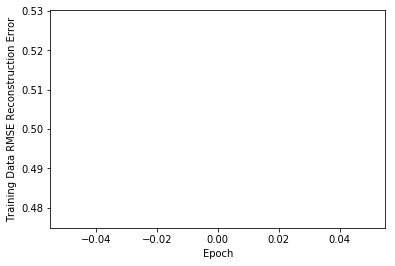

In [16]:
print('-------')
n_vis = user_reviews_df_exploded['item_id_int'].max() + 1
n_hidden = 12
batch_size = 128
reconerr = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))
print("start training")
for epoch in range(2):
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)



            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())
            
            # print(k)

        phk, _ = rbm.sample_h(vk)


        rbm.train(v0, vk, ph0, phk)
        
        train_recon_error += torch.sqrt(torch.mean((v0[v0 >= 0] - vk[v0 >= 0])**2))
        s += 1
        
    reconerr.append(train_recon_error / s)
    print('finished epoch', epoch)    
        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(reconerr)
plt.ylabel('Training Data RMSE Reconstruction Error')
plt.xlabel('Epoch')
plt.savefig('result.png')

# Evaluate the RBM on test set
test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
s = 0  # a counter (float type)

# for loop - go through every single user
for id_user in range(user_reviews_df_exploded['user_id_int'].max() + 1):
    v = train_matrix[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
    vt = test_matrix[id_user:id_user + 1]  # target

    if len(vt[vt >= 0]) > 0:
        _, h = rbm.sample_h(v)
        _, v = rbm.samrple_v(h)

        # Update test RMSE reconstruction error
        test_recon_error += torch.sqrt(torch.mean((vt[vt >= 0] - v[vt >= 0])**2))
        s += 1
        

In [19]:
torch.save(rbm.state_dict(), "./network")

In [18]:
rbm = RBM(n_vis, n_hidden)
rbm.load_state_dict(torch.load("./network"))
rbm.eval()



TypeError: train() missing 3 required positional arguments: 'vk', 'ph0', and 'phk'